In [6]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance as plot_lgb_importance
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [27]:
basic_log_loss = 1

def create_submission(X_test_processed):
    ensemble_proba_test = ensemble.predict_proba(X_test_processed)

    submission = pd.DataFrame(ensemble_proba_test, columns=['Status_C', 'Status_CL', 'Status_D'])

    submission['id'] = test['id']

    submission = submission[['id', 'Status_C', 'Status_CL', 'Status_D']]

    submission.to_csv('sample_submission.csv', index=False)

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importances, feature_names, model_name):

    # Сортировка признаков по их важности
    sorted_indices = importances.argsort()[::-1]
    sorted_importances = importances[sorted_indices]
    sorted_features = feature_names[sorted_indices]

    # Построение графика
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_importances, y=sorted_features, palette="viridis")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()


Feature importance for baseline_model: XGBoost:


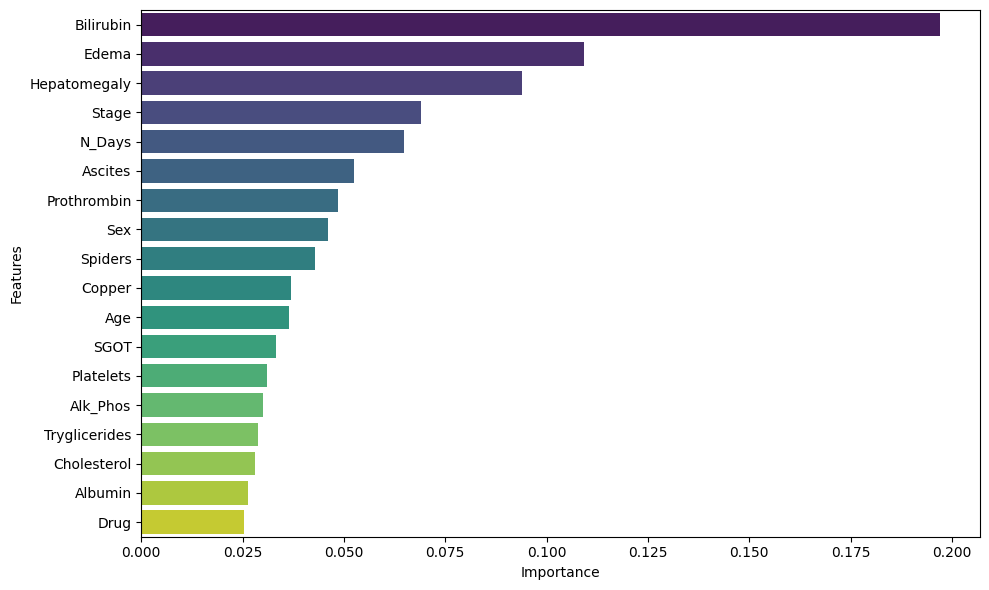

Baseline Log Loss: 0.5148


In [29]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X = train.drop(['id', 'Status'], axis=1)
y = train['Status']
X_test = test.drop('id', axis=1)

def preprocess_data(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())

    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df

def clip_probabilities(probabilities):
    eps = 1e-15
    return np.clip(probabilities, eps, 1 - eps)

X_processed = preprocess_data(X.copy())
X_test_processed = preprocess_data(X_test.copy())

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# XGBoost
baseline_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
baseline_model.fit(X_train, y_train_encoded)

baseline_proba = baseline_model.predict_proba(X_val)
baseline_proba = clip_probabilities(baseline_proba)

#plot
print("Feature importance for baseline_model: XGBoost:")
plot_feature_importance(baseline_model.feature_importances_, X_train.columns, "baseline_model: XGBoost")

# log loss
baseline_logloss = log_loss(y_val_encoded, baseline_proba)
print(f"Baseline Log Loss: {baseline_logloss:.4f}")


Feature importance for LightGBM:


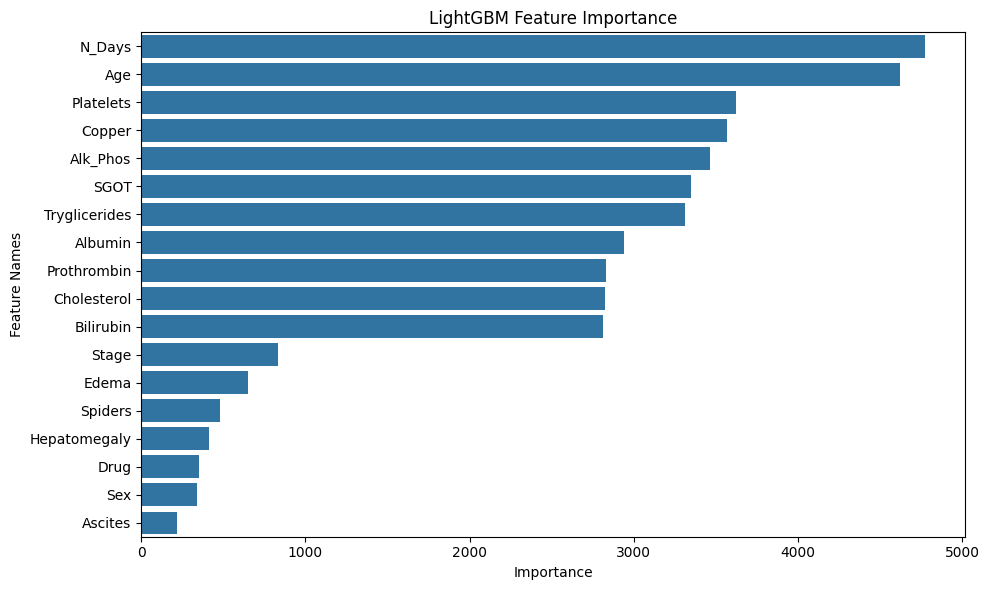

Feature importance for CatBoost:


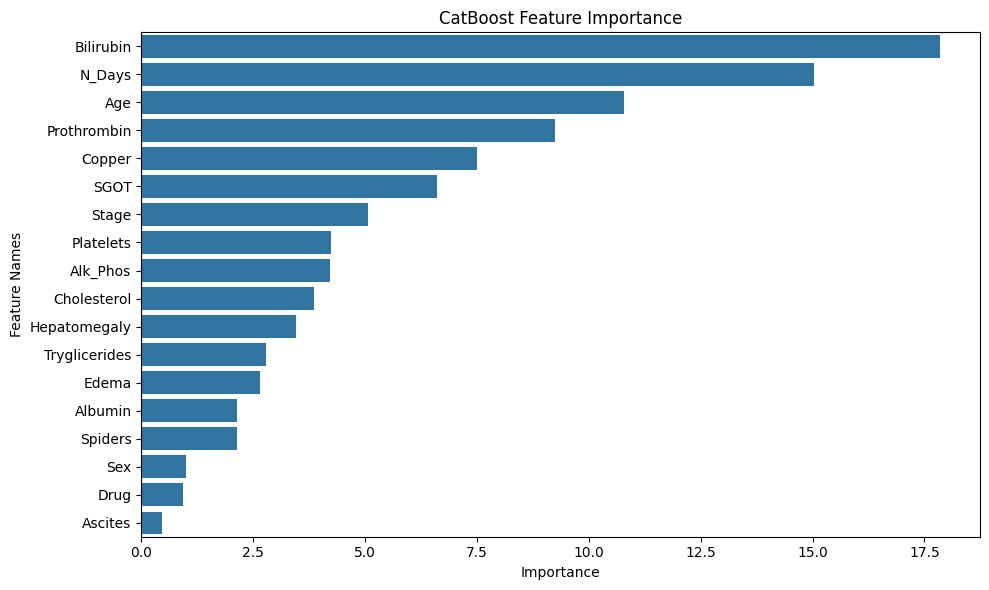

ldbm Log Loss: 0.4445
catboost Log Loss: 0.4757
Ensemble Log Loss: 0.4499


In [31]:
# features' importance plot
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'Feature Names': feature_names, 'Importance': feature_importance}
    df = pd.DataFrame(data)
    df = df.sort_values(by=['Importance'], ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=df['Importance'], y=df['Feature Names'])
    plt.title(f"{model_type} Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature Names")
    plt.tight_layout()
    plt.show()

X = train.drop(['id', 'Status'], axis=1)
y = train['Status']
X_test = test.drop('id', axis=1)

X_processed = preprocess_data(X.copy())
X_test_processed = preprocess_data(X_test.copy())

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# models training
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1
)
lgbm.fit(X_train, y_train_encoded)

lgbm_proba = lgbm.predict_proba(X_val)
lgbm_proba = np.clip(lgbm_proba, 1e-15, 1-1e-15)


catboost = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=3,
    random_state=42,
    verbose=False
)
catboost.fit(X_train, y_train_encoded)

catboost_proba = catboost.predict_proba(X_val)
catboost_proba = np.clip(catboost_proba, 1e-15, 1-1e-15)


# models' features importance and log_loss
print("Feature importance for LightGBM:")
plot_feature_importance(lgbm.feature_importances_, X_train.columns, "LightGBM")


print("Feature importance for CatBoost:")
plot_feature_importance(catboost.feature_importances_, X_train.columns, "CatBoost")

lgbm_logloss = log_loss(y_val_encoded, lgbm_proba)
print(f"ldbm Log Loss: {lgbm_logloss:.4f}")
catboost_logloss = log_loss(y_val_encoded, catboost_proba)
print(f"catboost Log Loss: {catboost_logloss:.4f}")


# Models' ensemle
ensemble_clear = VotingClassifier(
    estimators=[
        ('lgbm', lgbm),
        ('catboost', catboost)
    ],
    voting='soft',
    weights=[1, 1]
)

ensemble_clear.fit(X_train, y_train_encoded)

ensemble_proba = ensemble_clear.predict_proba(X_val)
ensemble_proba = np.clip(ensemble_proba, 1e-15, 1-1e-15)

ensemble_clear_logloss = log_loss(y_val_encoded, ensemble_proba)
print(f"Ensemble Log Loss: {ensemble_clear_logloss:.4f}")

clear_X_test_processed = X_test_processed

In [12]:
def generate_new_features(train_data, test_data):
    train_data_processed = train_data.copy()
    test_data_processed = test_data.copy()

    # Encoding binary features and categorical variables
    binary_features = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
    for feature in binary_features:
        train_data_processed[feature] = train_data_processed[feature].map({'N': 0, 'Y': 1})
        test_data_processed[feature] = test_data_processed[feature].map({'N': 0, 'Y': 1})

    # Encoding gender
    train_data_processed['Sex'] = train_data_processed['Sex'].map({'M': 0, 'F': 1})
    test_data_processed['Sex'] = test_data_processed['Sex'].map({'M': 0, 'F': 1})

    # One-Hot encoding of drugs
    train_data_processed = pd.get_dummies(train_data_processed, columns=['Drug'], drop_first=True)
    test_data_processed = pd.get_dummies(test_data_processed, columns=['Drug'], drop_first=True)

    # Generating age groups

    # Convert age to years
    train_data_processed['Age'] = train_data_processed['Age'] // 365
    test_data_processed['Age'] = test_data_processed['Age'] // 365


    def age_group(age):
        if age < 45:  # Conditional division by age groups
            return 'Young'
        elif age < 60:
            return 'Middle_Aged'
        else:
            return 'Elderly'

    train_data_processed['Age_Group'] = train_data_processed['Age'].apply(age_group)
    test_data_processed['Age_Group'] = test_data_processed['Age'].apply(age_group)

    # One-Hot encoding of age groups
    train_data_processed = pd.get_dummies(train_data_processed, columns=['Age_Group'], drop_first=True)
    test_data_processed = pd.get_dummies(test_data_processed, columns=['Age_Group'], drop_first=True)

    # Generating ratios between indicators
    train_data_processed['Bilirubin_Albumin_Ratio'] = train_data_processed['Bilirubin'] / train_data_processed['Albumin']
    train_data_processed['SGOT_Alk_Phos_Ratio'] = train_data_processed['SGOT'] / train_data_processed['Alk_Phos']

    test_data_processed['Bilirubin_Albumin_Ratio'] = test_data_processed['Bilirubin'] / test_data_processed['Albumin']
    test_data_processed['SGOT_Alk_Phos_Ratio'] = test_data_processed['SGOT'] / test_data_processed['Alk_Phos']

    train_data_processed['Bilirubin_Albumin_Ratio_Square'] = train_data_processed['Bilirubin_Albumin_Ratio'] ** 2
    test_data_processed['Bilirubin_Albumin_Ratio_Square'] = test_data_processed['Bilirubin_Albumin_Ratio'] ** 2

    # Logarithmic transformation of Bilirubin
    train_data_processed['Log_Bilirubin_Albumin_Ratio'] = train_data_processed['Bilirubin_Albumin_Ratio'].apply(lambda x: np.log(x) if x > 0 else 0)
    test_data_processed['Log_Bilirubin_Albumin_Ratio'] = test_data_processed['Bilirubin_Albumin_Ratio'].apply(lambda x: np.log(x) if x > 0 else 0)

    # Normalizing days by age
    train_data_processed['N_Days_Age_Ratio'] = train_data_processed['N_Days'] / train_data_processed['Age']
    test_data_processed['N_Days_Age_Ratio'] = test_data_processed['N_Days'] / test_data_processed['Age']

    # Polynomial features
    train_data_processed['Albumin_Cholesterol'] = train_data_processed['Albumin'] * train_data_processed['Cholesterol']
    test_data_processed['Albumin_Cholesterol'] = test_data_processed['Albumin'] * test_data_processed['Cholesterol']

    # Feature: Bilirubin deviation from median
    median_bilirubin_train = train_data_processed['Bilirubin'].median()
    median_bilirubin_test = test_data_processed['Bilirubin'].median()

    # Albumin percentage of maximum observed
    max_albumin_train = train_data_processed['Albumin'].max()
    max_albumin_test = test_data_processed['Albumin'].max()

    train_data_processed['Albumin_Percent_Max'] = train_data_processed['Albumin'] / max_albumin_train
    test_data_processed['Albumin_Percent_Max'] = test_data_processed['Albumin'] / max_albumin_test

    # Triglycerides to Bilirubin ratio
    train_data_processed['Triglycerides_Bilirubin_Ratio'] = train_data_processed['Tryglicerides'] / train_data_processed['Bilirubin']
    test_data_processed['Triglycerides_Bilirubin_Ratio'] = test_data_processed['Tryglicerides'] / test_data_processed['Bilirubin']

    # Biochemical anomaly (sum of absolute deviations)
    median_triglycerides_train = train_data_processed['Tryglicerides'].median()
    median_triglycerides_test = test_data_processed['Tryglicerides'].median()

    train_data_processed['Biochemical_Anomaly'] = (
        abs(train_data_processed['Bilirubin'] - median_bilirubin_train) +
        abs(train_data_processed['Tryglicerides'] - median_triglycerides_train)
    )
    test_data_processed['Biochemical_Anomaly'] = (
        abs(test_data_processed['Bilirubin'] - median_bilirubin_test) +
        abs(test_data_processed['Tryglicerides'] - median_triglycerides_test)
    )

    # Age to Albumin Ratio
    train_data_processed['Age_Albumin_Ratio'] = train_data_processed['Age'] / train_data_processed['Albumin']
    test_data_processed['Age_Albumin_Ratio'] = test_data_processed['Age'] / test_data_processed['Albumin']

    # Bilirubin-Cholesterol Difference
    train_data_processed['Bilirubin_Cholesterol_Diff'] = train_data_processed['Bilirubin'] - train_data_processed['Cholesterol']
    test_data_processed['Bilirubin_Cholesterol_Diff'] = test_data_processed['Bilirubin'] - test_data_processed['Cholesterol']

    return train_data_processed, test_data_processed


In [13]:
X, X_test = generate_new_features(X, X_test)


xgb Log Loss: 0.4597
ldbm Log Loss: 0.4491
catboost Log Loss: 0.4783
Feature importance for XGBoost:


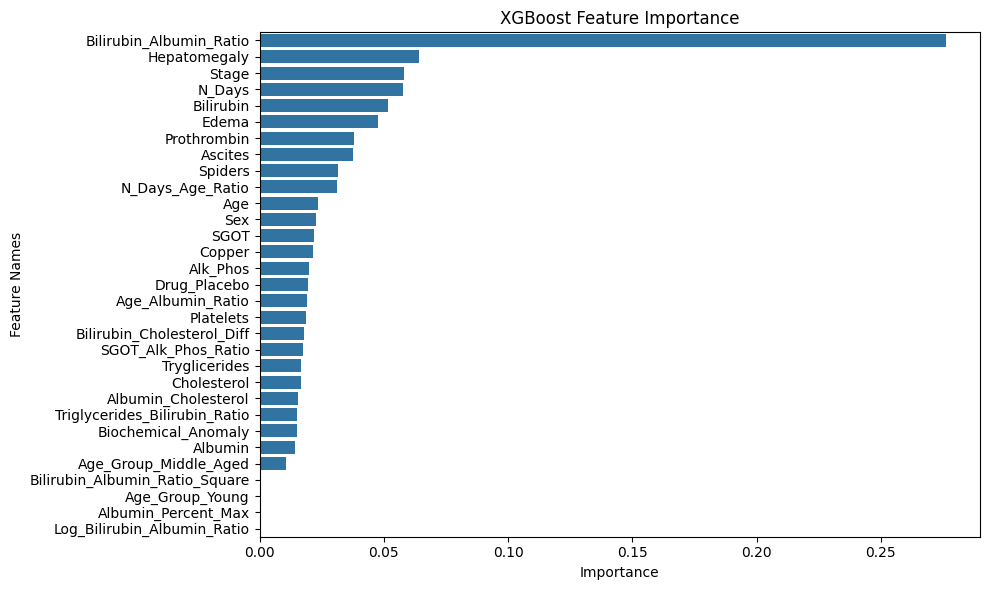

Feature importance for LightGBM:


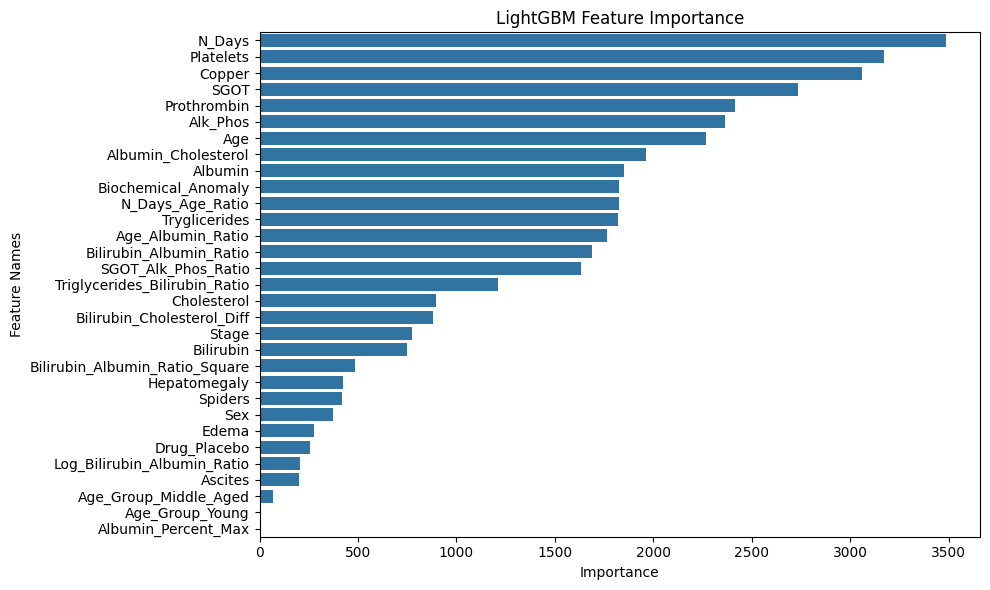

Feature importance for CatBoost:


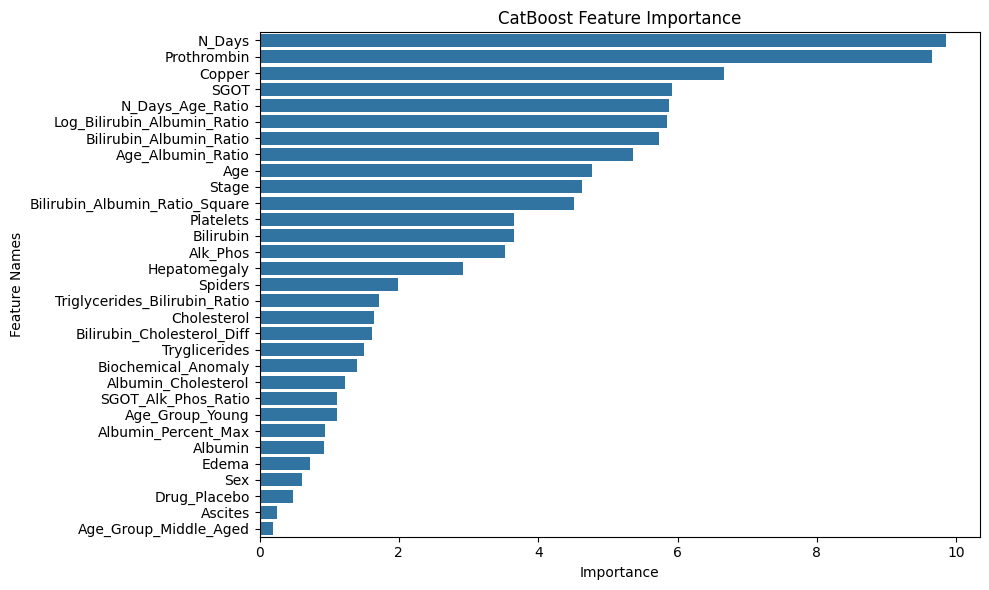

Ensemble Log Loss: 0.4531


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [14]:
X_processed = preprocess_data(X.copy())
X_test_processed = preprocess_data(X_test.copy())

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Training models
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)
xgb.fit(X_train, y_train_encoded)

xgb_proba = xgb.predict_proba(X_val)
xgb_proba = np.clip(xgb_proba, 1e-15, 1-1e-15)

xgb_logloss = log_loss(y_val_encoded, xgb_proba)
print(f"xgb Log Loss: {xgb_logloss:.4f}")

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1
)
lgbm.fit(X_train, y_train_encoded)

lgbm_proba = lgbm.predict_proba(X_val)
lgbm_proba = np.clip(lgbm_proba, 1e-15, 1-1e-15)

lgbm_logloss = log_loss(y_val_encoded, lgbm_proba)
print(f"ldbm Log Loss: {lgbm_logloss:.4f}")

catboost = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=3,
    random_state=42,
    verbose=False
)
catboost.fit(X_train, y_train_encoded)

catboost_proba = catboost.predict_proba(X_val)
catboost_proba = np.clip(catboost_proba, 1e-15, 1-1e-15)

catboost_logloss = log_loss(y_val_encoded, catboost_proba)
print(f"catboost Log Loss: {catboost_logloss:.4f}")

# Feautures importance
print("Feature importance for XGBoost:")
plot_feature_importance(xgb.feature_importances_, X_train.columns, "XGBoost")

print("Feature importance for LightGBM:")
plot_feature_importance(lgbm.feature_importances_, X_train.columns, "LightGBM")

print("Feature importance for CatBoost:")
plot_feature_importance(catboost.feature_importances_, X_train.columns, "CatBoost")

# Ensemble
feature_gen_ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('lgbm', lgbm),
        ('catboost', catboost)
    ],
    voting='soft',
    weights=[1, 1, 1]
)
feature_gen_ensemble.fit(X_train, y_train_encoded)

ensemble_proba = feature_gen_ensemble.predict_proba(X_val)
ensemble_proba = np.clip(ensemble_proba, 1e-15, 1-1e-15)

feature_gen_ensemble_logloss = log_loss(y_val_encoded, ensemble_proba)
print(f"Ensemble Log Loss: {feature_gen_ensemble_logloss:.4f}")

In [18]:
warnings.filterwarnings('ignore')

def create_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    for i, col1 in enumerate(numeric_cols):
        for col2 in numeric_cols[i+1:]:
            df[f'{col1}_{col2}_ratio'] = df[col1] / (df[col2] + 1e-6)
            df[f'{col1}_{col2}_product'] = df[col1] * df[col2]

    for col in numeric_cols:
        df[f'{col}_squared'] = df[col] ** 2
        df[f'{col}_cubed'] = df[col] ** 3

    return df

def add_noise(df, noise_level=0.01):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    noisy_df = df.copy()
    for col in numeric_cols:
        noise = np.random.normal(0, noise_level * df[col].std(), size=len(df))
        noisy_df[col] = df[col] + noise
    return noisy_df

def preprocess_data(df, is_training=True):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = df[col].clip(Q1 - 1.5*IQR, Q3 + 1.5*IQR)

    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    pt = PowerTransformer()
    df[numeric_cols] = pt.fit_transform(df[numeric_cols])

    df = create_features(df)

    if is_training:
        df = add_noise(df)

    return df

X = train.drop(['id', 'Status'], axis=1)
y = train['Status']
X_test = test.drop('id', axis=1)

X_processed = preprocess_data(X.copy(), is_training=True)
X_test_processed = preprocess_data(X_test.copy(), is_training=False)

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# training
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)
xgb.fit(X_train, y_train_encoded)

xgb_proba = xgb.predict_proba(X_val)
xgb_proba = np.clip(xgb_proba, 1e-15, 1-1e-15)

xgb_logloss = log_loss(y_val_encoded, xgb_proba)
print(f"xgb Log Loss: {xgb_logloss:.4f}")

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1
)
lgbm.fit(X_train, y_train_encoded)

lgbm_proba = lgbm.predict_proba(X_val)
lgbm_proba = np.clip(lgbm_proba, 1e-15, 1-1e-15)

lgbm_logloss = log_loss(y_val_encoded, lgbm_proba)
print(f"ldbm Log Loss: {lgbm_logloss:.4f}")

catboost = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=3,
    random_state=42,
    verbose=False
)
catboost.fit(X_train, y_train_encoded)

catboost_proba = catboost.predict_proba(X_val)
catboost_proba = np.clip(catboost_proba, 1e-15, 1-1e-15)

catboost_logloss = log_loss(y_val_encoded, catboost_proba)
print(f"catboost Log Loss: {catboost_logloss:.4f}")

noise_ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('lgbm', lgbm),
        ('catboost', catboost)
    ],
    voting='soft',
    weights=[1, 1, 1]
)

noise_ensemble.fit(X_train, y_train_encoded)

ensemble_proba = noise_ensemble.predict_proba(X_val)
ensemble_proba = np.clip(ensemble_proba, 1e-15, 1-1e-15)

noise_ensemble_logloss = log_loss(y_val_encoded, ensemble_proba)
print(f"Ensemble Log Loss: {noise_ensemble_logloss:.4f}")

xgb Log Loss: 0.4689
ldbm Log Loss: 0.4591
catboost Log Loss: 0.4876
Ensemble Log Loss: 0.4623


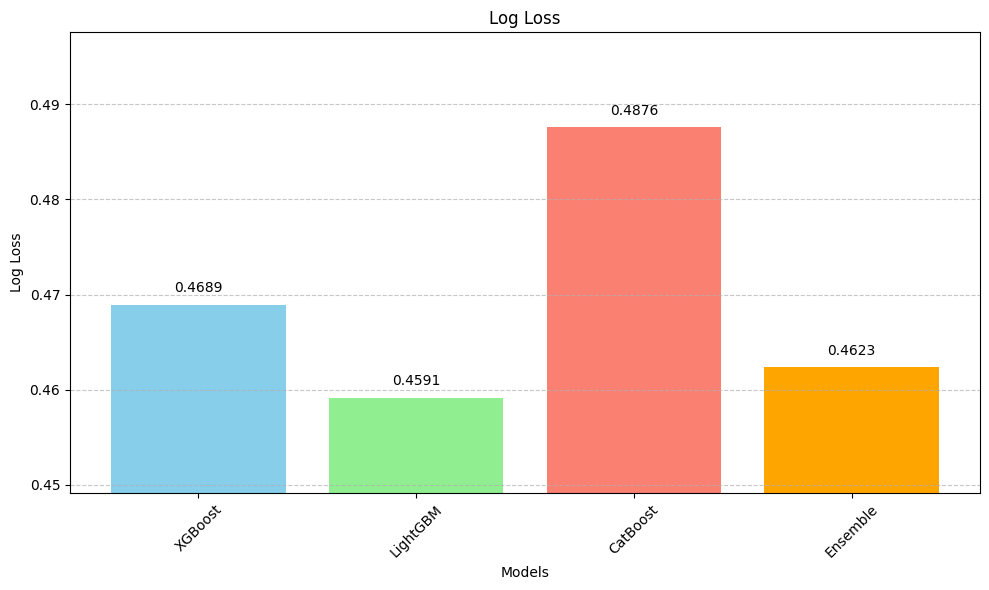

In [19]:
import matplotlib.pyplot as plt

logloss_scores = {
    'XGBoost': xgb_logloss,
    'LightGBM': lgbm_logloss,
    'CatBoost': catboost_logloss,
    'Ensemble': noise_ensemble_logloss
}

plt.figure(figsize=(10, 6))
plt.bar(logloss_scores.keys(), logloss_scores.values(), color=['skyblue', 'lightgreen', 'salmon', 'orange'])
plt.title('Log Loss')
plt.ylabel('Log Loss')
plt.xlabel('Models')
plt.ylim(min(logloss_scores.values()) - 0.01, max(logloss_scores.values()) + 0.01)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, (model, score) in enumerate(logloss_scores.items()):
    plt.text(i, score + 0.001, f'{score:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [20]:
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

# Data preprocessing
def preprocess_data(df, is_training=True):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = df[col].clip(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    pt = PowerTransformer()
    df[numeric_cols] = pt.fit_transform(df[numeric_cols])
    df = create_features(df)
    if is_training:
        df = add_noise(df)

    return df


# Training models
def train_models(X_train, y_train):
    xgb = XGBClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=6,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42
    )
    xgb.fit(X_train, y_train)

    lgbm = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=6,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        verbose=-1
    )
    lgbm.fit(X_train, y_train)

    catboost = CatBoostClassifier(
        iterations=500,
        learning_rate=0.01,
        depth=6,
        l2_leaf_reg=3,
        random_state=42,
        verbose=False
    )
    catboost.fit(X_train, y_train)

    return xgb, lgbm, catboost


# Ensemble model
def build_ensemble(xgb, lgbm, catboost):
    ensemble = VotingClassifier(
        estimators=[
            ('xgb', xgb),
            ('lgbm', lgbm),
            ('catboost', catboost)
        ],
        voting='soft',
        weights=[1, 1, 1]
    )
    return ensemble


X = train.drop(['id', 'Status'], axis=1)
y = train['Status']
X_test = test.drop('id', axis=1)

X_processed = preprocess_data(X.copy(), is_training=True)
X_test_processed = preprocess_data(X_test.copy(), is_training=False)

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Training models
xgb, lgbm, catboost = train_models(X_train, y_train_encoded)

xgb_test_proba = xgb.predict_proba(X_test_processed)
lgbm_test_proba = lgbm.predict_proba(X_test_processed)
catboost_test_proba = catboost.predict_proba(X_test_processed)

# Soft voting
test_proba_avg = (xgb_test_proba + lgbm_test_proba + catboost_test_proba) / 3
pseudo_labels = np.argmax(test_proba_avg, axis=1)

X_pseudo = np.vstack((X_train, X_test_processed))
y_pseudo = np.concatenate((y_train_encoded, pseudo_labels))

# Training on the extended dataset
label_ensemble = build_ensemble(xgb, lgbm, catboost)
label_ensemble.fit(X_pseudo, y_pseudo)

ensemble_val_proba = label_ensemble.predict_proba(X_val)
ensemble_label_enc_logloss = log_loss(y_val_encoded, ensemble_val_proba)
print(f"Ensemble Log Loss with Pseudo-labeling: {ensemble_label_enc_logloss:.4f}")


Ensemble Log Loss with Pseudo-labeling: 0.4756


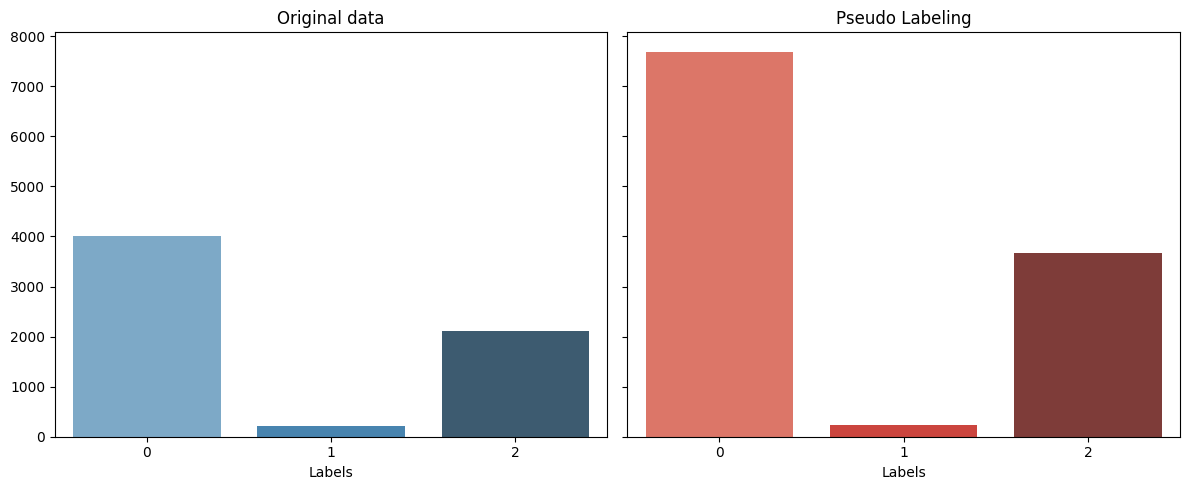

In [21]:
import seaborn as sns

original_label_counts = pd.Series(y_train_encoded).value_counts()
pseudo_label_counts = pd.Series(y_pseudo).value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.barplot(x=original_label_counts.index, y=original_label_counts.values, ax=axes[0], palette="Blues_d")
axes[0].set_title("Original data")
axes[0].set_xlabel("Labels")

sns.barplot(x=pseudo_label_counts.index, y=pseudo_label_counts.values, ax=axes[1], palette="Reds_d")
axes[1].set_title("Pseudo Labeling")
axes[1].set_xlabel("Labels")

plt.tight_layout()
plt.show()


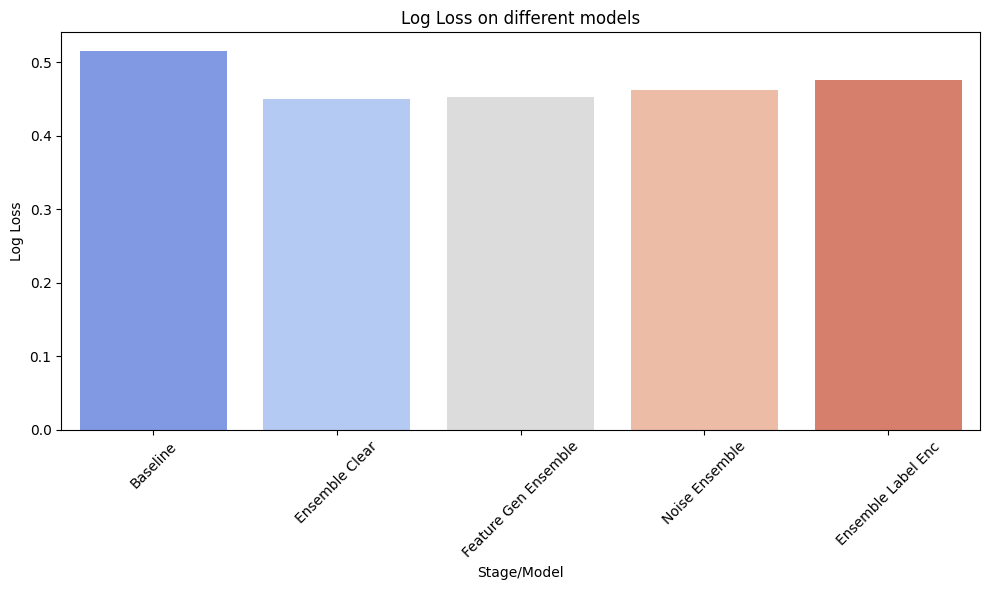

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Значения Log Loss для различных этапов/моделей
logloss_values = {
    "Baseline": baseline_logloss,
    "Ensemble Clear": ensemble_clear_logloss,
    "Feature Gen Ensemble": feature_gen_ensemble_logloss,
    "Noise Ensemble": noise_ensemble_logloss,
    "Ensemble Label Enc": ensemble_label_enc_logloss
}

def plot_logloss(logloss_dict):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(logloss_dict.keys()), y=list(logloss_dict.values()), palette="coolwarm")

    plt.title("Log Loss on different models")
    plt.ylabel("Log Loss")
    plt.xlabel("Stage/Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_logloss(logloss_values)


In [34]:
# Predict by ensemble model with best logloss

ensemble_models = {
    "ensemble_clear": {"model": ensemble_clear, "logloss": ensemble_clear_logloss},
    "feature_gen_ensemble": {"model": feature_gen_ensemble, "logloss": feature_gen_ensemble_logloss},
    "noise_ensemble": {"model": noise_ensemble, "logloss": noise_ensemble_logloss},
    "label_ensemble": {"model": label_ensemble, "logloss": ensemble_label_enc_logloss}
}

best_ensemble_name = min(ensemble_models, key=lambda k: ensemble_models[k]['logloss'])
best_ensemble = ensemble_models[best_ensemble_name]['model']
best_logloss = ensemble_models[best_ensemble_name]['logloss']

print(f"Best ensemble model: {best_ensemble_name} with Log Loss: {best_logloss:.4f}")

ensemble_proba_test = best_ensemble.predict_proba(clear_X_test_processed)
ensemble_proba_test = np.clip(ensemble_proba_test, 1e-15, 1 - 1e-15)

submission = pd.DataFrame(ensemble_proba_test, columns=['Status_C', 'Status_CL', 'Status_D'])
submission['id'] = test['id']
submission = submission[['id', 'Status_C', 'Status_CL', 'Status_D']]

submission.to_csv('sample_submission.csv', index=False)
print("Sample submission file created successfully with the best ensemble model!")



Best ensemble model: ensemble_clear with Log Loss: 0.4499
Sample submission file created successfully with the best ensemble model!
